In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os  
import sys  
sys.path.insert(0, os.getenv('HOME')+'/pycode/MscThesis/')
from amftrack.pipeline.functions.post_processing.extract_study_zone import *
import pandas as pd
import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.paths.directory import run_parallel, find_state, directory_scratch, directory_project
from amftrack.notebooks.analysis.util import * 
from scipy import stats
from scipy.ndimage.filters import uniform_filter1d
from collections import Counter
from IPython.display import clear_output
from amftrack.notebooks.analysis.data_info import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams.update({
    "font.family": "verdana",
'font.weight' : 'normal',
'font.size': 20})
from amftrack.plotutil import plot_node_skel
from amftrack.notebooks.validation.util import *
from amftrack.pipeline.paths.directory import *
from amftrack.util.sys import *
import pickle
from amftrack.pipeline.functions.post_processing.extract_study_zone import load_study_zone
from amftrack.pipeline.functions.post_processing.time_hypha import *
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Experiment, save_graphs, load_graphs, load_skel
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Edge

from shapely.geometry import Polygon, shape,Point
from scipy import spatial
from sklearn.preprocessing import StandardScaler
from amftrack.util.sys import temp_path


/home/cbisot/pycode/MscThesis/amftrack/transfer/functions/transfer.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
directory = directory_project
# update_analysis_info(directory)
analysis_info = get_analysis_info(directory)

In [5]:
select = analysis_info 
plate = '94'
rows = [row for (index, row) in select.iterrows()]
for index,row in enumerate(rows):
    path = f'{directory}{row["folder_analysis"]}'
    try:
        a = np.load(f'{path}/center.npy')
    except:
        pass
    if row["Plate"]== plate:
        path_exp = f'{directory}{row["path_exp"]}'
        exp = pickle.load(open(path_exp, "rb"))
        exp.dates.sort()
        break

In [5]:
try:
    exp.labeled
except AttributeError:
    exp.labeled = True

1


In [6]:
exp.labeled = True
load_study_zone(exp)
load_graphs(exp,indexes = [0])

In [7]:
%autoreload 2

time_plate_info,global_hypha_info,time_hypha_info = get_data_tables()


In [5]:
global_hypha_info.columns

Index(['t', 'tot_length', 'date', 'Plate', 'path_exp', 'folder_analysis',
       'num_trunks', 'area', 'area_sep_comp', 'num_tips',
       ...
       'ring_active_tips_density_incr-100_index-12',
       'ring_active_tips_density_incr-100_index-13',
       'ring_active_tips_density_incr-100_index-14',
       'ring_active_tips_density_incr-100_index-15',
       'ring_active_tips_density_incr-100_index-16',
       'ring_active_tips_density_incr-100_index-17',
       'ring_active_tips_density_incr-100_index-18',
       'ring_active_tips_density_incr-100_index-19', 'datetime',
       'time_since_begin'],
      dtype='object', length=118)

In [8]:
plates = time_plate_info['Plate'].unique()
ind_plate_table_time = {}
for plate in plates:
    ind_plate_table_time[plate]=time_plate_info.loc[time_plate_info['Plate']==plate].copy()

In [9]:
plates = time_plate_info['Plate'].unique()
ind_plate_table = {}
for plate in plates:
    ind_plate_table[plate]=time_plate_info.loc[time_plate_info['Plate']==plate].copy()
    

In [110]:
global_hypha_info['Plate'].unique()

array([799, 790, 792, 800, 80, 10, 76, 102, 94, 88, 26, 808, 152, 91, 785,
       787], dtype=object)

In [10]:
plates = global_hypha_info['Plate'].unique()
ind_hypha_table = {}
for plate in plates:
    table = global_hypha_info.loc[global_hypha_info['Plate']==plate].copy()
    table = table.set_index('hypha')
    ind_hypha_table[plate]=table

In [12]:
plates = [94]
for plate in plates:
    table = ind_plate_table[plate]
    table['total_length_m'] = table['tot_length_study']/10**6
    table['speed'] = table['tot_length_study'].diff(5)/table['time_since_begin'].diff(5)
    table['mean_step'] = np.mean(table['time_since_begin'].diff(1))
    table['density'] = table['tot_length_study']/(table['area_sep_comp']+1)
    table['ring_density'] = table['tot_length_study'].diff(10)/(table['area_sep_comp'].diff(10)+1)
    table['log_length_study'] = np.log2(table['tot_length_study'].astype(float))
    table['local_growth_rate'] = table['log_length_study'].diff(5)/table['time_since_begin'].diff(5)*24
    table_hypha = ind_hypha_table[plate]

In [22]:
plates = time_hypha_info['Plate'].unique()
time_hypha_table = {}
for plate in plates: 
    time_hypha_table[plate]=global_hypha_info.loc[global_hypha_info['Plate']==plate].copy()
    select_time_plate = ind_plate_table[plate]
    last_time = np.max(select_time_plate.loc[select_time_plate['out_study']==0]['time_since_begin'])
    # last_time2 = np.max(select_time_plate.loc[select_time_plate['local_growth_rate']>=0.5]['time_since_begin'])
    select_time = time_hypha_info.loc[time_hypha_info['Plate']==plate]
    select_time = select_time.loc[select_time['speed'].between(50,400)]
    select_global = global_hypha_info.loc[global_hypha_info['Plate']==plate]
    # select_time = select_time.loc[select_time['has_reached_final_pos']=='False']
    # select_time = select_time.loc[select_time['distance_final_pos']>200]
    select_time = select_time.loc[select_time['in_ROI']=='True']
    # select_time = select_time.loc[select_time['time_since_begin_exp']<=last_time2]
    select_time['speed'] = select_time['speed'].astype(float)
    time_hypha_table[plate] = select_time

In [32]:
plate = 94


In [40]:
table = ind_hypha_table[plate]
table_time = time_hypha_table[plate]
select_time = time_hypha_info.loc[time_hypha_info['Plate']==plate]
speed_at_init = table_time.loc[table_time['time_since_emergence']==0]
table['max_speed'] = table_time.groupby('end')['speed'].max()
table['mean_speed2'] = table_time.groupby('end')['speed'].mean()
table['log_length'] = np.log10((table['tot_length_C']+1).astype(float))
table['log_growth'] = np.log10((table['tot_growth_C']+1).astype(float))

table['growth_lapse'] = table_time.groupby('end')['speed'].count()
table['speed_at_init'] = speed_at_init.groupby('end')['speed'].max()
# table = table.loc[table['max_speed'].notnull()]
table = table.loc[table['av_width_final'].between(0,15)]
# table = table.loc[table['num_branch']>=0]
table = table.loc[table['tot_growth_C']>=200]
table = table.loc[table['max_speed'].between(50,400)]
# table['branch_frequ'] = table['num_branch']/(table['tot_growth_C']+1)
# table = table.loc[table['branch_frequ'].between(0,0.003)]
table = table.loc[table['log_length']>=2.3]


/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


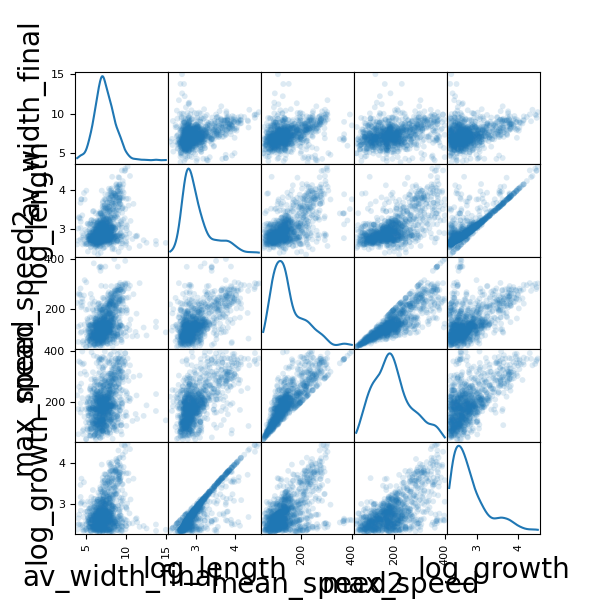

In [34]:
from pandas.plotting import scatter_matrix
scatter_matrix(table[['av_width_final','log_length','mean_speed2','max_speed','log_growth']].fillna(0), alpha=0.15, figsize=(6, 6), diagonal="kde",s=70);

In [41]:
# table = ind_hypha_table[plate]
# table_time = time_hypha_table[plate]
select_time = time_hypha_info.loc[time_hypha_info['Plate']==plate]
speed_at_init = table_time.loc[table_time['time_since_emergence']==0]
table['max_speed'] = table_time.groupby('end')['speed'].max()
table['mean_speed2'] = table_time.groupby('end')['speed'].mean()
table['log_length'] = np.log10((table['tot_length_C']+1).astype(float))
table['growth_lapse'] = table_time.groupby('end')['speed'].count()
table['speed_at_init'] = speed_at_init.groupby('end')['speed'].max()
# table = table.loc[table['max_speed'].notnull()]
# table = table.loc[table['av_width_final'].between(0,15)]
# table = table.loc[table['num_branch']>=1]
# table['branch_frequ'] = table['num_branch']/table['tot_length_C']
# table = table.loc[table['branch_frequ']<0.003]
# from sklearn.cluster import KMeans
# df = table[['log_length']].fillna(0)
# features = ['log_length']# Separating out the features
# # features = ['log_length','mean_speed2']# Separating out the features

# x = table.loc[:, features].values# Separating out the target
# # y = table.loc[:,['target']].values# Standardizing the features
# x = StandardScaler().fit_transform(x)
# kmeans = KMeans(n_clusters=3).fit(x)
# centroids = kmeans.cluster_centers_
# c= kmeans.labels_.astype(float)

# table['category'] = c
# table['is_rh'] = (table['category']==table.groupby('category')['max_speed'].mean().idxmax()).astype(int)
table['is_rh'] = (table['log_length']>=3.36).astype(int)
table['is_small'] = (table['log_length']<=2.3).astype(int)
table['is_bas'] = (table['log_length'].between(2.3,3.36)).astype(int)


<AxesSubplot:title={'center':'94'}, xlabel='log_length', ylabel='av_width_final'>

Text(0, 0.5, 'average width $(\\mu m)$')

Text(0.5, 0, 'log length $(log(\\mu m))$')

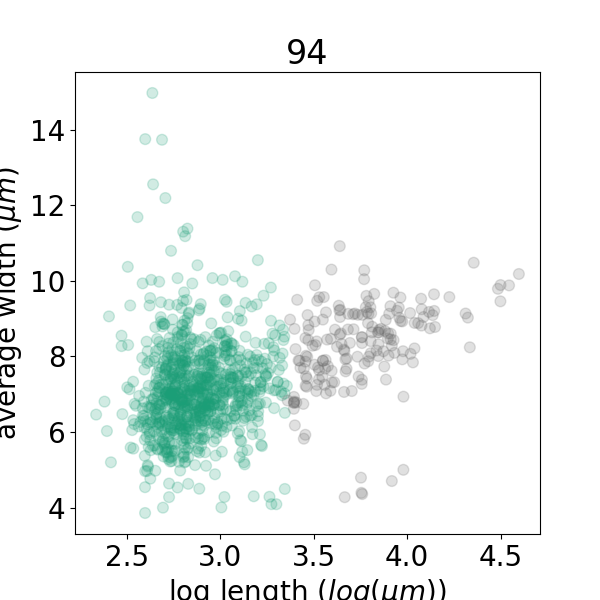

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ylabel = 'average width $(\mu m)$'
# ylabel = 'maximum speed $(\mu m.s^{-1})$'
xlabel = 'log length $(log(\mu m))$'

table.plot('log_length','av_width_final',c='is_rh',kind='scatter',colormap='Dark2',alpha = 0.2,s=60,ax=ax,title = plate,colorbar = False)
ax.set_ylabel(ylabel)
ax.set_xlabel(xlabel)
# ax.set_xlim(2.5,4.5)
# ax.set_ylim(50,400)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ylabel = 'average width $(\mu m)$'
# ylabel = 'maximum speed $(\mu m.s^{-1})$'
xlabel = 'log length $(log(\mu m))$'

table.plot('log_length','av_width_final',c='is_rh',kind='scatter',colormap='Dark2',alpha = 0.2,s=60,ax=ax,title = plate,colorbar = False)
ax.set_ylabel(ylabel)
ax.set_xlabel(xlabel)
# ax.set_xlim(2.5,4.5)
# ax.set_ylim(50,400)

In [220]:
segs = []
t=30
colors = []
for hyph in exp.hyphaes:
    if t in hyph.ts:
        try:
            nodes,edges = hyph.get_nodes_within(t)
            color = "red" if np.all(table.loc[table.index == hyph.end.label]['is_rh']) else "blue"
            color = 'green' if np.all(table.loc[table.index == hyph.end.label]['is_small']) else color
            for edge in edges:
                origin, end = edge.end.get_pseudo_identity(t).pos(t),edge.begin.get_pseudo_identity(t).pos(t)
                segs.append((origin, end))
                colors.append(color)
        except nx.exception.NetworkXNoPath:
            pass

In [181]:
greens = [hyph for hyph in exp.hyphaes if t in hyph.ts and np.all(table.loc[table.index == hyph.end.label]['is_bas'])]

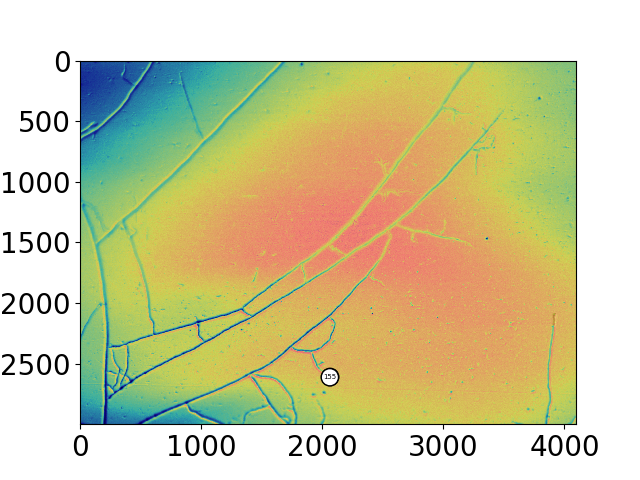

In [182]:
hypha = choice(greens)
hypha.end.show_source_image(t,t+1)

In [183]:
hypha.end.show_source_image(hyph.ts[-1],hyph.ts[-1])

KeyError: 155

In [178]:
hyph.ts[-1]

98

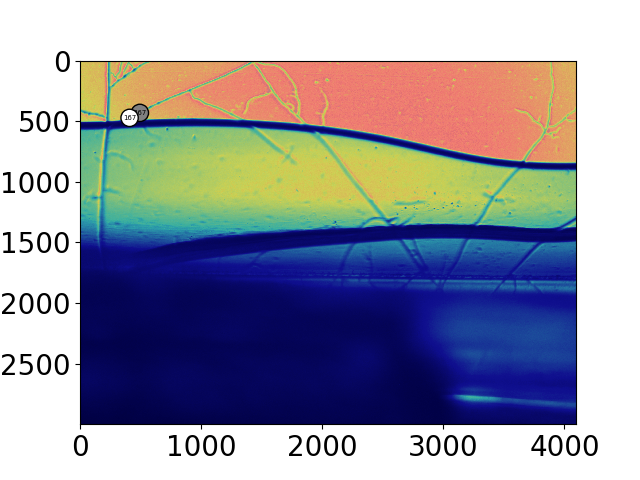

In [171]:
hypha.get_root(t).show_source_image(t,t+1)

In [186]:
global_hypha_info.loc[(global_hypha_info['Plate']==792)&(global_hypha_info['hypha']==hypha.end.label)]

,hypha,av_width_final,tot_length_C,tot_growth_C,Plate,path_exp,folder_analysis,timestep_anastomosis,tot_length_pp,tot_growth_pp,timestep_stop_growth,time_stop_growth,time_init_growth,mean_speed,strop_track,timestep_biological_stop_growth,num_branch,out_of_ROI,timestep_init_growth
13993,155,6.32061,490.153,0,792,Analysis_1637745064562052826_0_99_Version9/exp...,Analysis_1637745064562052826_0_99_Version9,None,461.269,34.3704,0,0,0,0,23,0,NaN,NaN,0


In [198]:
table.loc[table.index == hypha.end.label]

,av_width_final,tot_length_C,tot_growth_C,Plate,path_exp,folder_analysis,timestep_anastomosis,tot_length_pp,tot_growth_pp,timestep_stop_growth,...,timestep_init_growth,max_speed,mean_speed2,log_length,log_growth,growth_lapse,speed_at_init,is_rh,is_small,is_bas
hypha,,,,,,,,,,,,,,,,,,,,,
155,6.32061,490.153,0,792,Analysis_1637745064562052826_0_99_Version9/exp...,Analysis_1637745064562052826_0_99_Version9,None,461.269,34.3704,0,...,0,NaN,NaN,2.691217,0.0,NaN,NaN,0,0,1


In [176]:
nodes,edges = hypha.get_nodes_within(hyph.ts[-1])
edges

NetworkXNoPath: No path to 86.

In [221]:
segs = [(np.flip(origin)//5,np.flip(end)//5) for origin,end in segs]


In [120]:
seg2 = [seg for seg,color in zip(segs,colors) if color!="green"]
color2 = [color for seg,color in zip(segs,colors) if color!="green"]

In [222]:
skels = []
ims = []
kernel = np.ones((5,5),np.uint8)
itera = 2
folders = list(exp.folders['folder'])
folders.sort()
for folder in folders[t:t+1]:
    directory_name=folder
    path_snap=directory+directory_name
    skel_info = read_mat(path_snap+'/Analysis/skeleton_realigned_compressed.mat')
    skel = skel_info['skeleton']
    skels.append(cv2.dilate(skel.astype(np.uint8),kernel,iterations = itera))

Text(0.9, 0.9, 't = 0h')

findfont: Font family ['verdana'] not found. Falling back to DejaVu Sans.


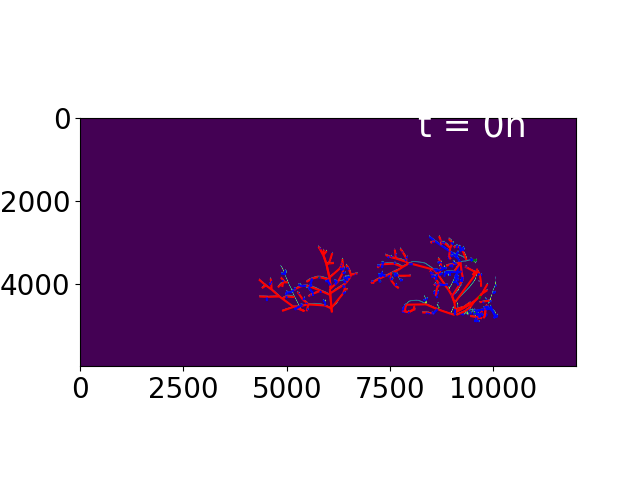

In [225]:
plt.close('all')
import matplotlib
i=0
ln_coll = matplotlib.collections.LineCollection(segs,colors=colors)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(skels[i])
ax.add_collection(ln_coll)
plt.draw()
right = 0.90
top = 0.85
fontsize = 25
ax.text(
    right,
    top,
    f't = {int(get_time(exp,0,i))}h',
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=ax.transAxes,
    color="white",
    fontsize=fontsize,
)
# plt.savefig(f'{temp_path}/{plate}_im{i}')

In [24]:
np.sum(table.loc[(table['is_rh']==1)&(table['strop_track']==99)]['tot_length_C'])/np.sum(table.loc[(table['is_rh']==0)&(table['strop_track']==99)]['tot_length_C'])

1.4723667565268603

In [66]:
t = 99
L=np.sum(table.loc[(table['is_rh']==1)&(table['strop_track']==t)]['tot_length_C'])+np.sum(table.loc[(table['is_rh']==0)&(table['strop_track']==t)]['tot_length_C'])

In [68]:
L/10**6

1.867082761116795

In [25]:
t = 25
hyphaes = table.loc[(table['strop_track']>=t)&(table['timestep_init_growth']<=t)]
rh = hyphaes.loc[(hyphaes['is_rh']==1)].index
bas = hyphaes.loc[(hyphaes['is_rh']==0)].index
L_rh = np.sum(table_time.loc[(table_time['end'].isin(rh))&(table_time['timestep']==t)]['tot_length_C'])
L_bas = np.sum(table_time.loc[(table_time['end'].isin(bas))&(table_time['timestep']==t)]['tot_length_C'])

In [123]:
def get_tot_L(table,table_time,t):
    hyphaes = table.loc[(table['strop_track']>=t)&(table['timestep_init_growth']<=t)]
    rh = hyphaes.loc[(hyphaes['is_rh']==1)].index
    bas = hyphaes.loc[(hyphaes['is_rh']==0)].index
    L_rh = np.sum(table_time.loc[(table_time['end'].isin(rh))&(table_time['timestep']==t)]['tot_length_C'])
    L_bas = np.sum(table_time.loc[(table_time['end'].isin(bas))&(table_time['timestep']==t)]['tot_length_C'])
    return(L_rh,L_bas)

In [105]:
table

,av_width_final,tot_length_C,tot_growth_C,Plate,path_exp,folder_analysis,timestep_anastomosis,tot_length_pp,tot_growth_pp,timestep_stop_growth,...,timestep_init_growth,max_speed,mean_speed2,log_length,log_growth,growth_lapse,speed_at_init,category,is_rh,is_small
hypha,,,,,,,,,,,,,,,,,,,,,
0,8.84555,32429.1,22804.5,792,Analysis_1637745064562052826_0_99_Version9/exp...,Analysis_1637745064562052826_0_99_Version9,NaN,NaN,NaN,NaN,...,0,305.886177,263.347745,4.510948,4.358040,43.0,244.584791,2.0,1,0
1,8.44987,5985.35,5738.83,792,Analysis_1637745064562052826_0_99_Version9/exp...,Analysis_1637745064562052826_0_99_Version9,NaN,NaN,NaN,NaN,...,0,2017.326265,83.111843,3.777162,3.758899,98.0,91.306650,2.0,1,0
4,6.64642,888.408,843.755,792,Analysis_1637745064562052826_0_99_Version9/exp...,Analysis_1637745064562052826_0_99_Version9,NaN,NaN,NaN,NaN,...,0,162.060346,20.148237,2.949101,2.926731,79.0,74.370316,0.0,0,0
7,10.0954,602.399,0,792,Analysis_1637745064562052826_0_99_Version9/exp...,Analysis_1637745064562052826_0_99_Version9,NaN,NaN,NaN,NaN,...,0,341.716864,242.091094,2.780604,0.000000,64.0,150.625680,0.0,0,0
8,6.37782,10092.5,3700.26,792,Analysis_1637745064562052826_0_99_Version9/exp...,Analysis_1637745064562052826_0_99_Version9,NaN,NaN,NaN,NaN,...,0,754.762700,132.490939,4.004041,3.568350,38.0,203.177665,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197833,6.16554,668.871,0,792,Analysis_1637745064562052826_0_99_Version9/exp...,Analysis_1637745064562052826_0_99_Version9,NaN,NaN,NaN,NaN,...,98,NaN,NaN,2.825991,0.000000,NaN,NaN,0.0,0,0
197834,7.99442,6206.2,0,792,Analysis_1637745064562052826_0_99_Version9/exp...,Analysis_1637745064562052826_0_99_Version9,NaN,NaN,NaN,NaN,...,98,NaN,NaN,3.792896,0.000000,NaN,NaN,2.0,1,0
197843,7.78493,272.107,0,792,Analysis_1637745064562052826_0_99_Version9/exp...,Analysis_1637745064562052826_0_99_Version9,NaN,NaN,NaN,NaN,...,98,NaN,NaN,2.436333,0.000000,NaN,NaN,1.0,0,0


In [208]:
whole_plate = ind_plate_table[plate]
in_study = whole_plate.loc[whole_plate['out_study']==0]
t_max = np.max(in_study['t'])

In [209]:
Ls = [get_tot_L(table,table_time,t) for t in range(t_max+1)]

In [210]:
L_rh, L_bas = list(zip(*Ls))
L_rh = np.array(L_rh)
L_bas = np.array(L_bas)

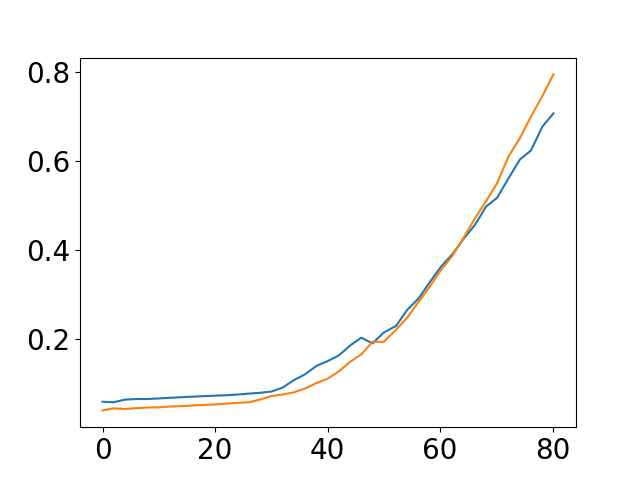

In [211]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(in_study["time_since_begin"],(L_rh+L_bas)/10**6)
ax.plot(in_study["time_since_begin"],in_study["total_length_m"])

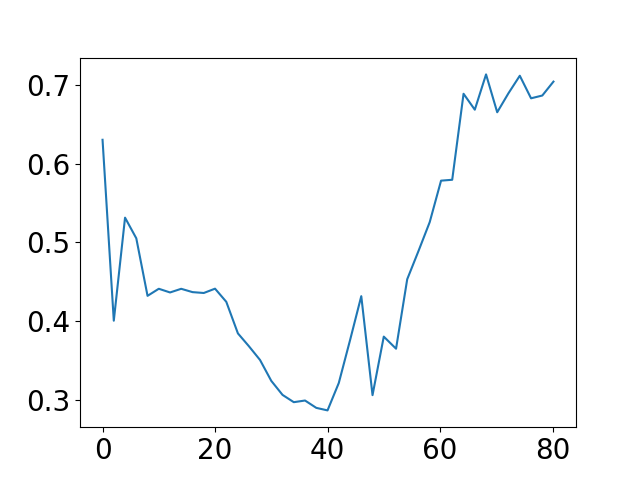

In [212]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(in_study["time_since_begin"],(L_bas/(L_rh+in_study["total_length_m"]*10**6-(L_rh+L_bas))))

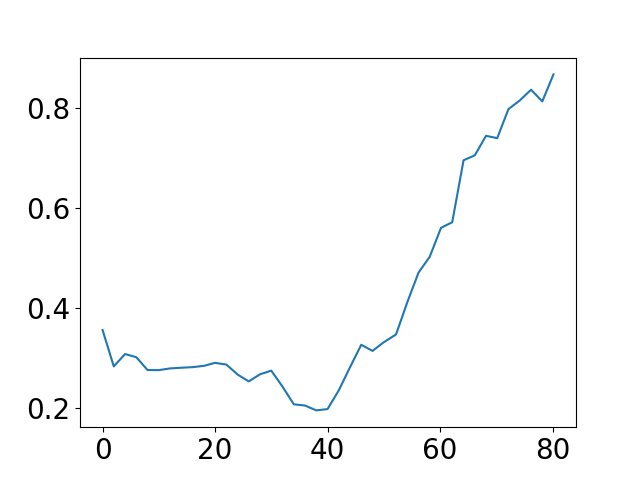

In [216]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(in_study["time_since_begin"],(L_bas/(L_rh)))

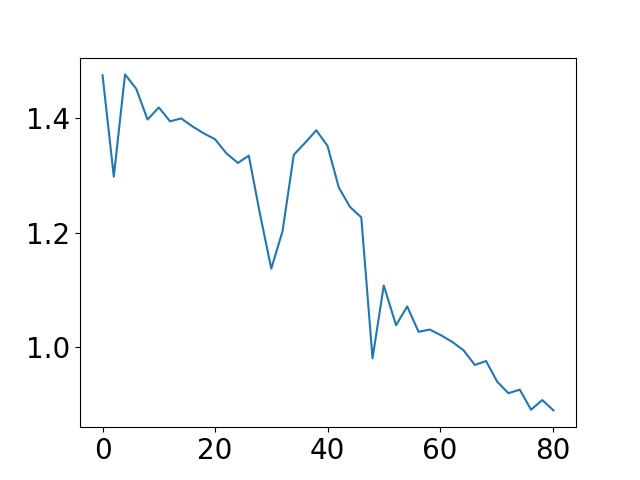

In [213]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(in_study["time_since_begin"],((L_bas+L_rh)/(in_study["total_length_m"]*10**6)))

In [48]:
np.max(ind_plate_table[94]["tot_length"])/10**6

2.2104305342508437

In [77]:
ind_plate_table[94].columns

Index(['t', 'tot_length', 'date', 'Plate', 'path_exp', 'folder_analysis',
       'num_trunks', 'area', 'area_sep_comp', 'num_tips',
       ...
       'ring_active_tips_density_incr-100_index-19', 'datetime',
       'time_since_begin', 'total_length_m', 'speed', 'mean_step', 'density',
       'ring_density', 'log_length_study', 'local_growth_rate'],
      dtype='object', length=125)

In [33]:
np.sum(table.loc[(table['is_rh']==0)&(table['strop_track']==99)]['tot_length_C'])

834683.9227476496

In [45]:
time_hypha_info.loc[time_hypha_info['Plate']==94].columns

Index(['end', 'distance_final_pos', 'timedelta', 'time_since_emergence',
       'speed', 'timestep', 'timestep_init', 'time_init', 'degree',
       'width_tip_edge', 'av_width', 'has_reached_final_pos', 'in_ROI',
       'time_since_begin_exp', 'width_root_edge', 'Plate', 'folder', 't',
       'density_window500', 'density_window1000', 'density_window2000'],
      dtype='object')